# Installing CLIP

In [1]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

     |████████████████████████████████| 63 kB 569 kB/s 
  Created wheel for ftfy: filename=ftfy-6.0.1-py3-none-any.whl size=41572 sha256=756919a34d602202746863be1a43e074d3c5bbc95822b6bef3923d683d1c842a
  Stored in directory: /root/.cache/pip/wheels/bb/10/8d/092bc0016be4948c3fe65c4a3e1354ac39ca7eff07e9f2df25
Successfully built ftfy
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-xus5jp4x
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-xus5jp4x
     |████████████████████████████████| 776.8 MB 8.5 kB/s 
     |████████████████████████████████| 12.8 MB 50.5 MB/s 
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1368708 sha256=e54b4eccaf4ddac6432e28fb1f58504780b6799e014b2074aa5a938cf4de3087
  Stored in directory: /tmp/pip-ephem-wheel-cache-_7dakkjn/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip
  Attempting uninstall: torch
    Found existing installation: torch 1.7.0
    Unin

In [2]:
from PIL import Image
import torch
from torch import nn, optim
import glob
import os
import pandas as pd
import json
import numpy as np
import clip
from torch.utils.data import Dataset, DataLoader, BatchSampler
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import random
from matplotlib.pyplot import imshow
import torchtext
import nltk, re, string, collections
from nltk.util import ngrams
import collections
%matplotlib inline
BATCH_SIZE = 128
EPOCH = 5

# Preparing Model and Data

In [3]:
IMG_ROOT = "../input/meme-project-raw"
JSON_ROOT = "../input/meme-project-clean-json"
img_paths = glob.glob(os.path.join(IMG_ROOT, "*.jpg"))
d = {}
for i, img_path in enumerate(img_paths):
    name = img_path.split("/")[-1].split(".")[0]
    with open(os.path.join(JSON_ROOT, name+".json"), "r") as f:
        captions = json.load(f)
        temp = []
        for cap in captions:
            if "http" not in (cap[0]+ ' '+cap[1]) and len(cap[0]+ ' '+cap[1]) >= 8 and len(cap[0]+ ' '+cap[1]) <= 72:
                temp.append(cap[0]+ ' '+cap[1])
        d[img_path] = temp
len(d)

3000

## Splitting 20% for Validation

In [4]:
train_img_paths, test_img_paths = train_test_split(img_paths, test_size=0.2, random_state=42)
d_train = {k: d[k] for k in train_img_paths}
d_test = {k: d[k] for k in test_img_paths}
len(d_train), len(d_test)

(2400, 600)

## Loading Pre-trained CLIP Model and Preprocessor

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

image = preprocess(Image.open("../input/meme-project-raw/-okay-.jpg")).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)
image.shape, text.shape

100%|███████████████████████████████████████| 354M/354M [00:03<00:00, 99.9MiB/s]


(torch.Size([1, 3, 224, 224]), torch.Size([3, 77]))

## MemeDataset

In [6]:
class MemeDataset(Dataset):
    def __init__(self, data, preprocess):
        self.preprocess = preprocess
        self.img_paths = []
        self.captions = []
        for img_path, captions in data.items():
            for cap in captions:
                self.img_paths.append(img_path)
                self.captions.append(cap)
        self.processed_cache = {}
        for img_path in data:
            self.processed_cache[img_path] = self.preprocess(Image.open(img_path))
        self.img_paths_set = list(data.keys())
        self.path2label = {path: self.img_paths_set.index(path) for path in self.img_paths_set}
        
    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = self.processed_cache[img_path]
        caption = self.captions[idx]
        label = self.path2label[img_path]
        return image, caption, label

train_dataset = MemeDataset(d_train, preprocess)
test_dataset = MemeDataset(d_test, preprocess)
len(train_dataset), len(test_dataset), train_dataset[0]

(238850,
 59887,
 (tensor([[[1.9011, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.8865],
           [1.9303, 1.9303, 1.8865,  ..., 1.8719, 1.9157, 1.9303],
           [1.9303, 1.8865, 1.7990,  ..., 1.7114, 1.8281, 1.9303],
           ...,
           [1.9303, 1.8573, 1.6968,  ..., 1.9157, 1.8719, 1.8865],
           [1.9157, 1.8719, 1.7990,  ..., 1.8719, 1.8865, 1.9157],
           [1.7990, 1.9011, 1.9303,  ..., 1.8865, 1.9303, 1.9303]],
  
          [[2.0749, 2.0599, 2.0149,  ..., 2.0299, 2.0149, 2.0599],
           [2.0599, 2.0749, 2.0599,  ..., 2.0749, 2.0599, 2.0149],
           [2.0149, 2.0599, 2.0749,  ..., 2.0749, 2.0749, 2.0149],
           ...,
           [2.0449, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
           [2.0599, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0599],
           [2.0749, 2.0599, 2.0149,  ..., 2.0749, 2.0749, 2.0749]],
  
          [[2.1032, 2.0464, 2.0606,  ..., 2.0037, 2.1032, 2.1459],
           [2.0464, 2.1032, 2.1459,  ..., 2.0464, 2.1175, 2.1459],
     

In [7]:
i = 0
for k,v in train_dataset.path2label.items():
    i+=1
    print(k,v)
    if i == 10:
        break

../input/meme-project-raw/typical-proger-new.jpg 0
../input/meme-project-raw/mitt-romney-meme.jpg 1
../input/meme-project-raw/typical-kpi.jpg 2
../input/meme-project-raw/drake-quotes.jpg 3
../input/meme-project-raw/blank-black.jpg 4
../input/meme-project-raw/andy-infante.jpg 5
../input/meme-project-raw/naginata-rage.jpg 6
../input/meme-project-raw/close-enough.jpg 7
../input/meme-project-raw/roleplay-panther.jpg 8
../input/meme-project-raw/whipped-boyfriend-perry.jpg 9


## BalancedBatchSampler (ensures no same class per batch)

In [8]:
# https://github.com/pytorch/pytorch/blob/e5742494f6080c8e6f43c37689fc18a7c4b39dfd/torch/utils/data/dataloader.py#L145
class BalancedBatchSampler(BatchSampler):
    """
    BatchSampler - from a MNIST-like dataset, samples n_classes and within these classes samples n_samples.
    Returns batches of size n_classes * n_samples
    """

    def __init__(self, labels, n_classes, n_samples):
        self.labels = labels
        self.labels_set = list(set(self.labels.numpy()))
        self.label_to_indices = {label: np.where(self.labels.numpy() == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.n_dataset = len(self.labels)
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < self.n_dataset:
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return self.n_dataset // self.batch_size
    
train_labels = torch.tensor([item[2] for item in train_dataset])
train_sampler = BalancedBatchSampler(train_labels, BATCH_SIZE, 1)
train_dataloader = DataLoader(train_dataset, batch_sampler=train_sampler)

test_labels = torch.tensor([item[2] for item in test_dataset])
test_sampler = BalancedBatchSampler(test_labels, BATCH_SIZE, 1)
test_dataloader = DataLoader(test_dataset, batch_sampler=test_sampler)

# train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=False)
# len(train_dataset), len(test_dataset), train_dataset[0]

In [9]:
for i, item in enumerate(train_sampler):
#     print(item)
#     print(len(item))
    labels = []
    for idx in item:
        label = train_dataset[idx][2]
        labels.append(label)
    break
len(labels), len(set(labels))

(128, 128)

In [10]:
for batch in train_dataloader:
    imgs, txts, labels = batch
    print(imgs.shape)
    print(len(txts))
    print(labels)
    print(labels.shape)
    print(torch.unique(labels).shape)
    break

torch.Size([128, 3, 224, 224])
128
tensor([2262, 1065,  929,  821,  621, 2223, 1329,  251, 2388,  629, 1875,  449,
        1142, 2386,  954,  817, 1567,   76,  425,  805,   37,  254,  860, 1963,
        1300, 1943, 2376,  825,  101, 1115,  733,  791, 2011, 1928, 1916,  556,
        1443,  923, 1111, 2148,  345, 1277, 2019, 1892, 2127, 1025,  975,  603,
         379, 1183,  448, 2160,  964,  641, 2321,  950,  711, 1200,  471, 1791,
        1530, 1245,  436,  905, 2275, 1910,  530,  434, 1410,  546,  262, 2152,
         351, 1998,  456,  874, 1917,  203, 1466, 1367, 2198,  575,  285, 2333,
         759, 1865,  131, 1109, 1015, 2188, 1298,  972,  123,  415, 1296, 2307,
        1755, 2363, 1024,  538, 1793,  748,  615,  469,  239,  235, 1535, 1006,
         563, 1772, 2287, 1561, 1604, 2205,   28, 1002,  529,   26, 1258,  240,
         682,  984, 2061,  655,  517, 2241,  226, 2300])
torch.Size([128])
torch.Size([128])


# Training

In [11]:
#https://github.com/openai/CLIP/issues/57
def convert_models_to_fp32(model): 
    for p in model.parameters(): 
        p.data = p.data.float() 
        p.grad.data = p.grad.data.float() 

if device == "cpu":
    model.float()

loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=5e-5,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2)
optimizer = optim.Adam(model.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, len(train_dataloader)*EPOCH)

In [12]:
best_te_loss = 1e5
best_ep = -1
for epoch in range(EPOCH):
    print(f"running epoch {epoch}, best test loss {best_te_loss} after epoch {best_ep}")
    step = 0
    tr_loss = 0
    model.train()
    pbar = tqdm(train_dataloader, leave=False)
    for batch in pbar:
        step += 1
        optimizer.zero_grad()

        images, texts, _ = batch
        images = images.to(device)
        texts = clip.tokenize(texts).to(device)
#         print(images.shape, texts.shape)
        logits_per_image, logits_per_text = model(images, texts)
        ground_truth = torch.arange(BATCH_SIZE).to(device)

        total_loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2
        total_loss.backward()
        tr_loss += total_loss.item()
        if device == "cpu":
            optimizer.step()
            scheduler.step()
        else:
            convert_models_to_fp32(model)
            optimizer.step()
            scheduler.step()
            clip.model.convert_weights(model)
        pbar.set_description(f"train batchCE: {total_loss.item()}", refresh=True)
    tr_loss /= step
    
    step = 0
    te_loss = 0
    with torch.no_grad():
        model.eval()
        test_pbar = tqdm(test_dataloader, leave=False)
        for batch in test_pbar:
            step += 1
            images, texts, _ = batch
            images = images.to(device)
            texts = clip.tokenize(texts).to(device)
            logits_per_image, logits_per_text = model(images, texts)
            ground_truth = torch.arange(BATCH_SIZE).to(device)

            total_loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2
            te_loss += total_loss.item()
            test_pbar.set_description(f"test batchCE: {total_loss.item()}", refresh=True)
        te_loss /= step
        
    if te_loss < best_te_loss:
        best_te_loss = te_loss
        best_ep = epoch
        torch.save(model.state_dict(), "best_model.pt")
    print(f"epoch {epoch}, tr_loss {tr_loss}, te_loss {te_loss}")
torch.save(model.state_dict(), "last_model.pt")

running epoch 0, best test loss 100000.0 after epoch -1


  0%|          | 0/1866 [00:00<?, ?it/s]

  0%|          | 0/467 [00:00<?, ?it/s]

epoch 0, tr_loss 2.504419651828778, te_loss 3.9768636241970023
running epoch 1, best test loss 3.9768636241970023 after epoch 0


  0%|          | 0/1866 [00:00<?, ?it/s]

  0%|          | 0/467 [00:00<?, ?it/s]

epoch 1, tr_loss 1.5385723870411308, te_loss 4.430214467344753
running epoch 2, best test loss 3.9768636241970023 after epoch 0


  0%|          | 0/1866 [00:00<?, ?it/s]

  0%|          | 0/467 [00:00<?, ?it/s]

epoch 2, tr_loss 1.0258153197849678, te_loss 5.2167257762312635
running epoch 3, best test loss 3.9768636241970023 after epoch 0


  0%|          | 0/1866 [00:00<?, ?it/s]

  0%|          | 0/467 [00:00<?, ?it/s]

epoch 3, tr_loss 0.6899755545367765, te_loss 5.645376070663811
running epoch 4, best test loss 3.9768636241970023 after epoch 0


  0%|          | 0/1866 [00:00<?, ?it/s]

  0%|          | 0/467 [00:00<?, ?it/s]

epoch 4, tr_loss 0.5830189335895632, te_loss 5.719569726980728


# Evaluating Precision on Validation Set

In [13]:
model.load_state_dict(torch.load("../input/clipfinetuneweights/best_model.pt"))
NUM_NEG = 127
NUM_TEST = 1000

In [14]:
n_correct = 0
for i in tqdm(range(NUM_TEST)):
    empty = True
    while empty:
        img_path = random.choice(list(d_test.keys()))
        image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
        name = img_path.split('/')[-1].split('.')[0]
        caps = d_test[img_path]
        if len(caps) > 0:
            pos_txt = random.choice(caps)
        #         pos_txt = ' '.join(pos_txt)
            empty = False
#     print(pos_txt)
    neg_i = 0
    neg_txts = []
    while neg_i < NUM_NEG:
        img_path = random.choice(list(d_test.keys()))
        neg_name = img_path.split('/')[-1].split('.')[0]
        if neg_name == name:
            continue
        caps = d_test[img_path]
        if len(caps) == 0:
            continue
        neg_txt = random.choice(caps)
        if neg_txt in neg_txts:
            continue
        neg_txts.append(neg_txt)
        neg_i += 1
#     print(name)
#     print(f"Positive caption: {pos_txt}")
#     print(f"Negative caption: {neg_txts}")
    text = clip.tokenize([pos_txt]+neg_txts).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)

        logits_per_image, logits_per_text = model(image, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()

#     print("Label probs:", probs)
#     print(np.argmax(probs))
    if np.argmax(probs) == 0:
        n_correct +=1
print(f"Test precision {n_correct/NUM_TEST}")

  0%|          | 0/1000 [00:00<?, ?it/s]

Test precision 0.192


# Evaluating BLEU and Word Diversity using Naive Sampling

## Sampling Captions for Validation Images According to CLIP Text-Image Proximity

In [15]:
def sample1Caption(img_path, corpus, model, num_cand):
    image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
    i = 0
    txts = []
    while i < num_cand:
        txt = random.choice(corpus)
        if txt in txts:
            continue
        if len(txt.split())<5 or len(txt)>72:
            continue
        txts.append(txt)
        i += 1
    #     print(name)
    #     print(f"Positive caption: {pos_txt}")
    #     print(f"Negative caption: {neg_txts}")
    text = clip.tokenize(txts).to(device)

    with torch.no_grad():
        logits_per_image, logits_per_text = model(image, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    #     print("Label probs:", probs)
    #     print(np.argmax(probs))
    #     imshow(np.asarray(Image.open(img_path)))
    return txts[np.argmax(probs)]

In [16]:
model.load_state_dict(torch.load("../input/clipfinetuneweights/best_model.pt"))
corpus = []
for txtlist in d_train.values():
    corpus += txtlist
len(corpus), corpus[0]

(238850, 'tells you to check a qr code its a trap')

In [17]:
captions = {}
for img_path in tqdm(d_test.keys()):
    caption = sample1Caption(img_path, corpus, model, 1000)
    captions[img_path] = caption

  0%|          | 0/600 [00:00<?, ?it/s]

## BLEU Score

In [18]:
for get_bleu in range(1,4):
    bleu_x_lst = []
    bleu_y_lst = []
    for p, caps in d_test.items():
        if not caps:
            continue
        bleu_x_lst.append(captions[p].split())
        splittedcaps = [x.split() for x in caps]
        bleu_y_lst.append(splittedcaps)
    BLEU = torchtext.data.metrics.bleu_score(bleu_x_lst, bleu_y_lst, max_n=get_bleu, weights=[1/get_bleu]*get_bleu)
    print(f"{get_bleu}-gram BLEU score: {BLEU}")

1-gram BLEU score: 0.3719640374183655
2-gram BLEU score: 0.15723450481891632
3-gram BLEU score: 0.08657167851924896


## Word Diversity

In [19]:
sentences = list(captions.values())
BigramCtr = collections.Counter()
UnigramCtr = collections.Counter()
for sentence in sentences:
    BigramCtr.update(nltk.ngrams(sentence, 2))
    UnigramCtr.update(nltk.ngrams(sentence, 1))
# print("Unigram count:",len(BigramCtr)/len(sentences))
# print("Bigram count:",len(UnigramCtr)/len(sentences))
print("Unigram count:",len(BigramCtr))
print("Bigram count:",len(UnigramCtr))

Unigram count: 1346
Bigram count: 82


# Case Analysis on Seen and Unseen Images

Some ground truth captions for this seen image: ['iphone charger cord y u no reach bed?', 'Stuffy nose y u switch nostrils', "youtube's advertising y u no let me skip u?", 'Americans Y u no learn something about the rest of the world?', 'MEME GEN ASK\'S "Y U NO LOG IN" I ASK,Y U NO LET ME SIGN UP?']
Caption sampled by fintuned CLIP for this seen image: ap why you no have stronger password?


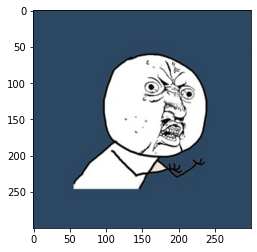

In [20]:
seen_path = random.choice(list(d_train.keys()))
pred_cap_seen = sample1Caption(seen_path, corpus, model, 1000)
gt_cap_seen = d_train[seen_path][:5]
imshow(Image.open(seen_path))
print(f"Some ground truth captions for this seen image: {gt_cap_seen}")
print(f"Caption sampled by fintuned CLIP for this seen image: {pred_cap_seen}")

Some ground truth captions for this unseen image: ['Is it Because I Is black?', 'Shut Up You Little Batty Boy', 'Swagger Spec respek', "TALK TO DA HAND COZ THA FACE AIN'T LISTENING!!", 'new hip hop sensation mr. yo thug']
Caption sampled by fintuned CLIP for this unseen image: I'm so gangster  I in the bloods 


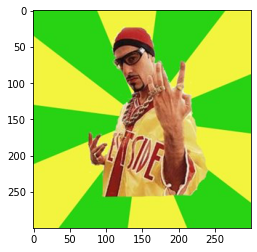

In [21]:
unseen_path = random.choice(list(d_test.keys()))
pred_cap_unseen = sample1Caption(unseen_path, corpus, model, 1000)
imshow(Image.open(unseen_path))
gt_cap_unseen = d_test[unseen_path][:5]
print(f"Some ground truth captions for this unseen image: {gt_cap_unseen}")
print(f"Caption sampled by fintuned CLIP for this unseen image: {pred_cap_unseen}")